<a id='phase1'></a>
## **Data Preparation**

<a id='import'></a>
### **Imports & Installations**

In [ ]:
# !pip install kagglehub
# !pip install openpyxl

In [ ]:
import xml.etree.ElementTree as ET
import kagglehub
import os
import pandas as pd

<a id='step01'></a>
### **Data Loading**

In [ ]:
# path_to_dataset = "content"
"""
If the dataset is not downloaded to your local machine you can use the following
commented command:
"""
path_to_dataset = kagglehub.dataset_download("andrewmvd/car-plate-detection")

annotation_folder = os.path.join(path_to_dataset, "annotations")
image_folder = os.path.join(path_to_dataset, "images")

<a id='step02'></a>
### **Data Parsing & Cleaning**

In [ ]:
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = {
        'width': root.find('size/width').text,
        'height': root.find('size/height').text
    }

    objects = [{
            'bndbox': {
                'xmin': object.find('bndbox/xmin').text,
                'ymin': object.find('bndbox/ymin').text,
                'xmax': object.find('bndbox/xmax').text,
                'ymax': object.find('bndbox/ymax').text,
            }
        } for object in root.findall('object')]

    extracted_info = {
        'folder': root.find('folder').text,
        'filename': root.find('filename').text,
        'size': size,
        'objects': objects
    }

    return extracted_info


<a id='step03'></a>
### **Data Flattening**

In [ ]:
records = []
for file in os.listdir(annotation_folder):
    if file.endswith(".xml"):
        data = parse_xml(os.path.join(annotation_folder, file))
        for obj in data["objects"]:
            row = {
                "filename": data["filename"],
                "xmin": int(obj["bndbox"]["xmin"]),
                "ymin": int(obj["bndbox"]["ymin"]),
                "xmax": int(obj["bndbox"]["xmax"]),
                "ymax": int(obj["bndbox"]["ymax"])
            }
            records.append(row)


<a id='step04'></a>
### **Converting Data to PD Data Frame**

In [ ]:
df = pd.DataFrame(records)
print(df.head(15))

       filename  xmin  ymin  xmax  ymax
0   Cars339.png   209   135   283   169
1    Cars13.png   191   147   242   169
2    Cars74.png   115   115   277   153
3    Cars16.png    36   175    62   186
4   Cars291.png    71   205   215   246
5   Cars236.png   223   106   250   119
6   Cars429.png    86   166   208   195
7   Cars132.png    23   190    56   198
8   Cars132.png   378   188   400   200
9   Cars251.png   136   134   210   153
10   Cars51.png   264   141   318   162
11  Cars165.png   209   217   293   254
12  Cars313.png   176   211   252   246
13  Cars240.png   171   116   232   132
14  Cars201.png   216   171   367   208


## **Model Development**

### Spliting the Data

We’ll split the annotated DataFrame (df) into training (70%), validation (15%), and test (15%) sets.

In [ ]:
from sklearn.model_selection import train_test_split

unique_filenames = df['filename'].unique()

train_files, temp_files = train_test_split(unique_filenames, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

df_train = df[df['filename'].isin(train_files)].reset_index(drop=True)
df_val = df[df['filename'].isin(val_files)].reset_index(drop=True)
df_test = df[df['filename'].isin(test_files)].reset_index(drop=True)

print(f"Train images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Test images: {len(test_files)}")

Train images: 303
Validation images: 65
Test images: 65


### Defining a Custom Dataset Class

we can use it with a DataLoader for training Faster R-CNN.

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image
import torch
import torchvision.transforms as T

class NumberPlateDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = df['filename'].unique()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['filename'] == image_id]

        img_path = os.path.join(self.image_dir, image_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        boxes = []
        labels = []

        for _, row in records.iterrows():
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([hash(image_id) % (2**31)])
        }

        return image, target


In [ ]:
## Instantiate Datasets
train_dataset = NumberPlateDataset(df_train, image_folder)
val_dataset = NumberPlateDataset(df_val, image_folder)
test_dataset = NumberPlateDataset(df_test, image_folder)

img, target = train_dataset[0]
print(img.shape)
print(target)


torch.Size([3, 268, 400])
{'boxes': tensor([[191., 147., 242., 169.]]), 'labels': tensor([1]), 'image_id': tensor([559330665])}


### Create DataLoaders with a Custom `collate_fn`

Faster R-CNN expects batches of data where:

* Each image can be a different size
* Each target is a dictionary (not a single tensor)

So we need a `collate_fn` to combine samples into a batch.

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

### Load and Customize the Faster R-CNN Model

We’ll load a pre-trained Faster R-CNN model and modify the **classification head** to match our dataset — in our case, there’s only **1 class: number plate**, plus background (so 2 total classes).

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# 2. Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 3. Replace the head with a new one (2 classes: background + number plate)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

print(model.roi_heads.box_predictor)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 108MB/s]


FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


### Moving Model to Device (GPU if available)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### Seting up an optimizer

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

This is the setup used in the [official PyTorch object detection tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

We also add a Learning Rate Scheduler to decay the learning rate after some epochs:

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### Evaluation Metrics: IoU and Detection Performance

#### Intersection over Union (IoU)

To evaluate the accuracy of predicted bounding boxes, we implemented the IoU metric, which measures the overlap between a predicted box and the ground truth box.

In [ ]:
def compute_iou(boxA, boxB):
    """
    Each box is defined as [x_min, y_min, x_max, y_max].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height

    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = inter_area / float(boxA_area + boxB_area - inter_area + 1e-6)
    return iou

#### Matching Predictions to Ground Truth

For each predicted box, we compute its IoU with all ground truth boxes and match it to the one with the highest IoU (if above a threshold).

In [ ]:
def calculate_image_iou(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Matches predicted boxes to ground truth boxes and calculates IoU.

    Returns:
        matched_ious: List of IoUs for matched boxes
        num_correct: Number of predictions with IoU > threshold
    """
    matched_ious = []
    num_correct = 0
    matched_gt = set()

    for pred_box in pred_boxes:
        best_iou = 0.0
        best_gt_idx = -1
        for idx, gt_box in enumerate(gt_boxes):
            if idx in matched_gt:
                continue
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        if best_iou >= iou_threshold:
            matched_ious.append(best_iou)
            num_correct += 1
            matched_gt.add(best_gt_idx)

    return matched_ious, num_correct


### Model Evaluation Loop

We apply the above functions to compute detection performance over the entire dataset, reporting Precision and Recall.

In [ ]:
def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_iou = 0.0
    total_images = 0
    total_correct = 0
    total_preds = 0
    total_gts = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu().numpy()
                gt_boxes = target['boxes'].cpu().numpy()

                _, num_correct = calculate_image_iou(pred_boxes, gt_boxes, iou_threshold)
                total_correct += num_correct
                total_preds += len(pred_boxes)
                total_gts += len(gt_boxes)

            total_images += len(images)

    precision = total_correct / (total_preds + 1e-6)
    recall = total_correct / (total_gts + 1e-6)

    print(f"Evaluation Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")

    return precision, recall


### Model Training and Evaluation

In [ ]:
import time
from tqdm import tqdm

def train_one_epoch(model, data_loader, optimizer, device, epoch, print_freq=50):
    model.train()
    epoch_loss = 0
    start_time = time.time()

    for i, (images, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}")):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        if (i + 1) % print_freq == 0:
            print(f"[Epoch {epoch} | Step {i + 1}] Loss: {total_loss.item():.4f}")

    avg_loss = epoch_loss / len(data_loader)
    print(f"\nEpoch {epoch} completed in {time.time() - start_time:.2f}s - Avg Loss: {avg_loss:.4f}")
    return avg_loss


In [ ]:
def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_iou = 0.0
    total_gt_boxes = 0
    matched_gt_boxes = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for pred, gt in zip(outputs, targets):
                pred_boxes = pred['boxes'].cpu()
                gt_boxes = gt['boxes'].cpu()

                total_gt_boxes += len(gt_boxes)

                for gt_box in gt_boxes:
                    best_iou = 0.0
                    for pred_box in pred_boxes:
                        iou = compute_iou(gt_box.numpy(), pred_box.numpy())
                        best_iou = max(best_iou, iou)

                    total_iou += best_iou
                    if best_iou >= iou_threshold:
                        matched_gt_boxes += 1

    avg_iou = total_iou / total_gt_boxes
    detection_rate = matched_gt_boxes / total_gt_boxes
    print(f"\n🔍 Evaluation Results:")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Detection Rate @ IoU > {iou_threshold}: {detection_rate * 100:.2f}%")

    return avg_iou, detection_rate


In [ ]:
ious = []
detection_rates = []

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, train_loader, optimizer, device, epoch)

    print(f"\n🔍 Evaluating after epoch {epoch}...")
    avg_iou, detection_rate = evaluate_model(model, val_loader, device)

    ious.append(avg_iou)
    detection_rates.append(detection_rate)

Epoch 1:  66%|██████▌   | 50/76 [01:29<00:44,  1.72s/it]

[Epoch 1 | Step 50] Loss: 0.0956


Epoch 1: 100%|██████████| 76/76 [02:17<00:00,  1.81s/it]



Epoch 1 completed in 137.46s - Avg Loss: 0.1717

🔍 Evaluating after epoch 1...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.36it/s]



🔍 Evaluation Results:
Average IoU: 0.7295
Detection Rate @ IoU > 0.5: 94.29%


Epoch 2:  66%|██████▌   | 50/76 [01:32<00:50,  1.94s/it]

[Epoch 2 | Step 50] Loss: 0.0405


Epoch 2: 100%|██████████| 76/76 [02:21<00:00,  1.86s/it]



Epoch 2 completed in 141.11s - Avg Loss: 0.0802

🔍 Evaluating after epoch 2...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.44it/s]



🔍 Evaluation Results:
Average IoU: 0.7625
Detection Rate @ IoU > 0.5: 94.29%


Epoch 3:  66%|██████▌   | 50/76 [01:33<00:48,  1.85s/it]

[Epoch 3 | Step 50] Loss: 0.0540


Epoch 3: 100%|██████████| 76/76 [02:20<00:00,  1.85s/it]



Epoch 3 completed in 140.54s - Avg Loss: 0.0698

🔍 Evaluating after epoch 3...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.42it/s]



🔍 Evaluation Results:
Average IoU: 0.7446
Detection Rate @ IoU > 0.5: 92.86%


Epoch 4:  66%|██████▌   | 50/76 [01:32<00:49,  1.90s/it]

[Epoch 4 | Step 50] Loss: 0.0462


Epoch 4: 100%|██████████| 76/76 [02:20<00:00,  1.85s/it]



Epoch 4 completed in 140.50s - Avg Loss: 0.0597

🔍 Evaluating after epoch 4...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.42it/s]



🔍 Evaluation Results:
Average IoU: 0.7508
Detection Rate @ IoU > 0.5: 90.00%


Epoch 5:  66%|██████▌   | 50/76 [01:34<00:47,  1.81s/it]

[Epoch 5 | Step 50] Loss: 0.0284


Epoch 5: 100%|██████████| 76/76 [02:21<00:00,  1.87s/it]



Epoch 5 completed in 141.79s - Avg Loss: 0.0534

🔍 Evaluating after epoch 5...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.42it/s]



🔍 Evaluation Results:
Average IoU: 0.7471
Detection Rate @ IoU > 0.5: 92.86%


Epoch 6:  66%|██████▌   | 50/76 [01:32<00:52,  2.03s/it]

[Epoch 6 | Step 50] Loss: 0.0517


Epoch 6: 100%|██████████| 76/76 [02:21<00:00,  1.86s/it]



Epoch 6 completed in 141.62s - Avg Loss: 0.0525

🔍 Evaluating after epoch 6...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.43it/s]



🔍 Evaluation Results:
Average IoU: 0.7441
Detection Rate @ IoU > 0.5: 94.29%


Epoch 7:  66%|██████▌   | 50/76 [01:33<00:49,  1.92s/it]

[Epoch 7 | Step 50] Loss: 0.0591


Epoch 7: 100%|██████████| 76/76 [02:20<00:00,  1.85s/it]



Epoch 7 completed in 140.85s - Avg Loss: 0.0443

🔍 Evaluating after epoch 7...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.41it/s]



🔍 Evaluation Results:
Average IoU: 0.7462
Detection Rate @ IoU > 0.5: 92.86%


Epoch 8:  66%|██████▌   | 50/76 [01:34<00:46,  1.80s/it]

[Epoch 8 | Step 50] Loss: 0.0340


Epoch 8: 100%|██████████| 76/76 [02:21<00:00,  1.86s/it]



Epoch 8 completed in 141.40s - Avg Loss: 0.0412

🔍 Evaluating after epoch 8...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.43it/s]



🔍 Evaluation Results:
Average IoU: 0.7289
Detection Rate @ IoU > 0.5: 91.43%


Epoch 9:  66%|██████▌   | 50/76 [01:32<00:47,  1.82s/it]

[Epoch 9 | Step 50] Loss: 0.0322


Epoch 9: 100%|██████████| 76/76 [02:21<00:00,  1.86s/it]



Epoch 9 completed in 141.65s - Avg Loss: 0.0389

🔍 Evaluating after epoch 9...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.42it/s]



🔍 Evaluation Results:
Average IoU: 0.7441
Detection Rate @ IoU > 0.5: 91.43%


Epoch 10:  66%|██████▌   | 50/76 [01:32<00:47,  1.84s/it]

[Epoch 10 | Step 50] Loss: 0.0214


Epoch 10: 100%|██████████| 76/76 [02:21<00:00,  1.86s/it]



Epoch 10 completed in 141.09s - Avg Loss: 0.0371

🔍 Evaluating after epoch 10...


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.43it/s]


🔍 Evaluation Results:
Average IoU: 0.7415
Detection Rate @ IoU > 0.5: 91.43%


### Evaluation on Test Data

In [ ]:
print("Final evaluation on test data...")
test_avg_iou, test_detection_rate = evaluate_model(model, test_loader, device)

print(f"\nTest Results:\n- Average IoU: {test_avg_iou:.4f}\n- Detection Rate: {test_detection_rate:.4f}")

Final evaluation on test data...


Evaluating: 100%|██████████| 33/33 [00:14<00:00,  2.31it/s]


🔍 Evaluation Results:
Average IoU: 0.7735
Detection Rate @ IoU > 0.5: 94.44%

Test Results:
- Average IoU: 0.7735
- Detection Rate: 0.9444


### Plot IoU and Detection Rate

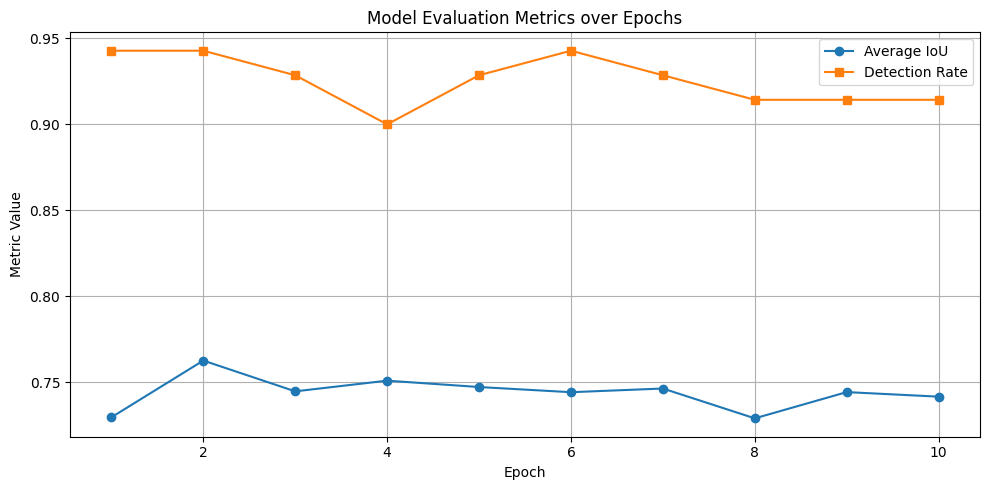

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, ious, label='Average IoU', marker='o')
plt.plot(epochs, detection_rates, label='Detection Rate', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Evaluation Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualizing 5 Random Test Predictions

In [ ]:
import matplotlib.patches as patches
import random
import torchvision.transforms.functional as F

def visualize_predictions(model, dataset, device, num_images=5, score_threshold=0.5):
    """
    Visualizes predictions from the model on random samples from the dataset.
    Draws both predicted and ground-truth bounding boxes.
    """
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    for i, idx in enumerate(indices):
        image, target = dataset[idx]
        img_tensor = image.to(device).unsqueeze(0)
        with torch.no_grad():
            prediction = model(img_tensor)[0]

        img = image.cpu()
        img = F.to_pil_image(img)

        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img)
        ax.set_title(f"Image #{idx}")
        ax.axis('off')

        for box in target['boxes']:
            x_min, y_min, x_max, y_max = box
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, 'GT', color='green', fontsize=10, weight='bold')

        for box, score in zip(prediction['boxes'], prediction['scores']):
            if score >= score_threshold:
                x_min, y_min, x_max, y_max = box.cpu()
                width, height = x_max - x_min, y_max - y_min
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, f"Pred ({score:.2f})", color='red', fontsize=10, weight='bold')

        plt.show()

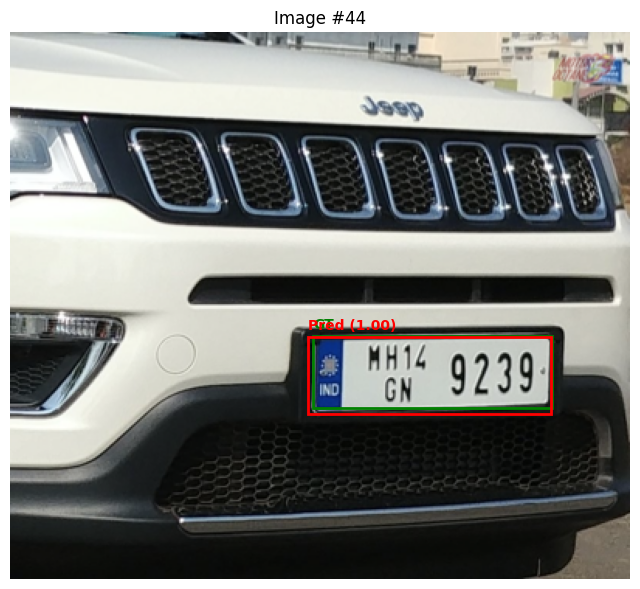

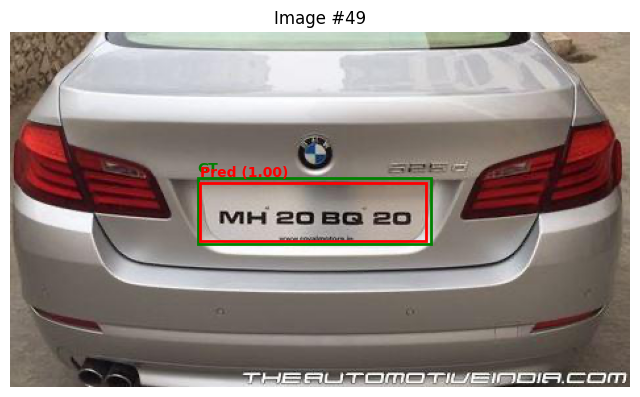

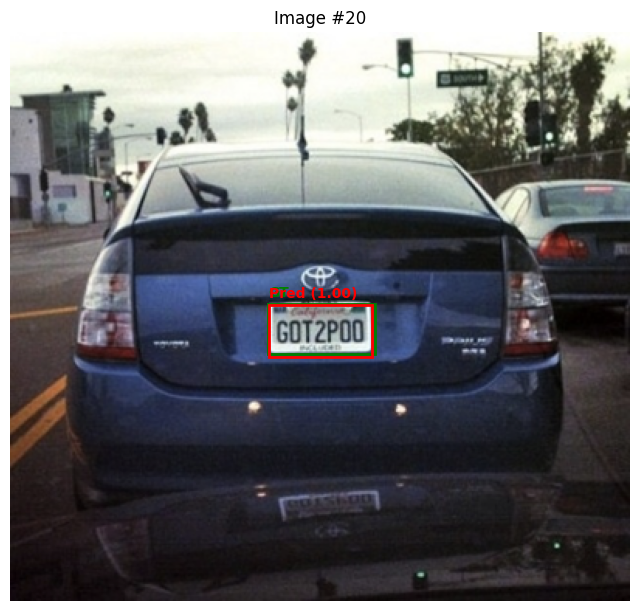

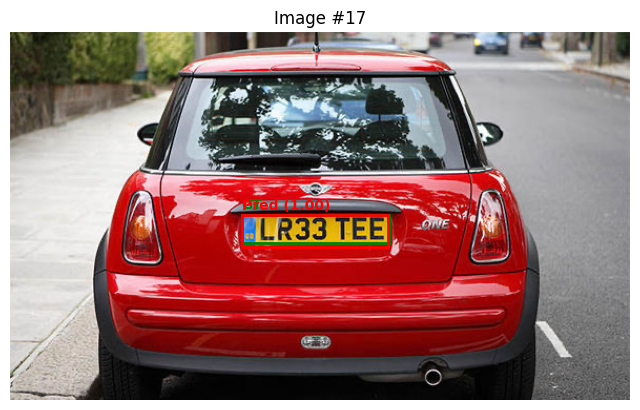

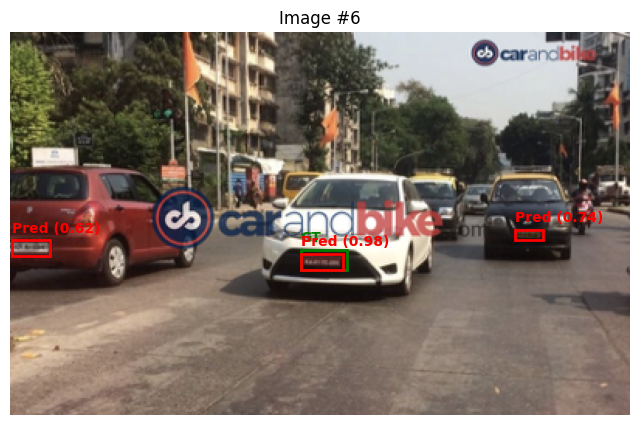

In [ ]:
visualize_predictions(model, test_dataset, device, num_images=5, score_threshold=0.5)